# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [1]:
# import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt


In [2]:
"""Load from /home/USER/data/mnist or elsewhere; download if missing."""

import gzip
import os
from urllib.request import urlretrieve
import numpy as np


def mnist(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    url = 'http://yann.lecun.com/exdb/mnist/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']

    if path is None:
        # Set path to /home/USER/data/mnist or C:\Users\USER\data\mnist
        path = os.path.join(os.path.expanduser('~'), 'data', 'mnist')

    # Create path if it doesn't exist
    os.makedirs(path, exist_ok=True)

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))
    print("All files are ready to gzip!")

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)
        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)
    print("Train Images : Loading . . .")
    train_images = _images(os.path.join(path, files[0]))
    print("Train Labels : Loading . . .")
    train_labels = _labels(os.path.join(path, files[1]))
    print("Test Images  : Loading . . .")
    test_images = _images(os.path.join(path, files[2]))
    print("Test Labels  : Loading . . .")
    test_labels = _labels(os.path.join(path, files[3]))
    print("Done!")

    return train_images, train_labels, test_images, test_labels

In [3]:
train_images, train_labels, test_images, test_labels = mnist()

All files are ready to gzip!
Train Images : Loading . . .
Train Labels : Loading . . .
Test Images  : Loading . . .
Test Labels  : Loading . . .
Done!


In [4]:
print(train_images.shape)
print(train_labels.shape) # ONE-HOT !!!
#print(train_images.T.shape)
#print(train_labels.reshape((train_images.shape[0], 10)).shape)
y = train_images[1].reshape(1,28,28)
#print(y.squeeze().shape)
'''
temp = []
#train_labels = train_labels.sum(1)
for i in range(int(len(train_labels[:]))):
    temp.append(list(train_labels[i][:]).index(1))
    
    
train_labels = np.array(temp.copy())
#print(train_labels[0:5])
'''
pass

(60000, 784)
(60000, 10)


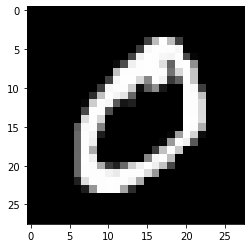

In [5]:
plt.imshow(y.squeeze(), cmap='Greys_r');

In [6]:
###### Architecture ######

NN_ARCHITECTURE = [
    {"input_dim": 784, "output_dim": 512, "activation": "relu"},
    {"input_dim": 512, "output_dim": 512, "activation": "relu"},
    {"input_dim": 512, "output_dim": 10, "activation": "sigmoid"} #Or relu again like the original example
]#No Dropout...yet


######  Init Layers  ######

def init_layers(nn_architecture, seed = 99):
    # random seed initiation
    np.random.seed(seed)
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # parameters storage initiation
    params_values = {}

    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1

        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]

        # initiating the values of the W matrix
        # and vector b for subsequent layers
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1

    return params_values

In [7]:
### Activation Functions ###
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

In [8]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    # calculation of the input value for the activation function
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # selection of activation function
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    # return of calculated activation A and the intermediate Z matrix
    return activation_func(Z_curr), Z_curr

def full_forward_propagation(X, params_values, nn_architecture):
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = X
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        # extraction of W for the current layer
        W_curr = params_values["W" + str(layer_idx)]
        # extraction of b for the current layer
        b_curr = params_values["b" + str(layer_idx)]
        # calculation of activation for the current layer
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # return of prediction vector and a dictionary containing intermediate values
    return A_curr, memory

In [9]:
###### Cost Calculations ######
def NLLLoss(logs, targets):
    out = []
    for i in range(len(targets)):
        out.append(logs[i][targets[i]])
    out = np.array(out)
    
    return -out.sum()/len(out)

def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost) ### ATTENTION!


###### Accuracy Calculation ######

# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_


def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

In [10]:
#######  BACK PROPAGATION  #######

def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # number of examples
    m = A_prev.shape[1]
    
    # selection of activation function
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')

    # calculation of the activation function derivative
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # derivative of the matrix W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    
    # derivative of the vector b
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # derivative of the matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr 


def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # initiation of gradient descent algorithm
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)

        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr

    return grads_values

In [11]:
###### UPDATE ######

def update(params_values, grads_values, nn_architecture, learning_rate):

    # iteration over network layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

In [35]:
######  TRAIN  ######
import torch
import time
time.time()


def train(X, Y, nn_architecture, epochs, learning_rate, verbose=True, callback=None):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    
    ####### Building index labels from One-Hot matrix #######
    temp = []
    #train_labels = train_labels.sum(1)
    for i in range(Y.shape[1]):
        for j in range(Y.shape[0]):
            if(Y[j][i]==1):
                temp.append(j)
    #########################################################
    X_t = X.copy()
    Y_t = Y.copy()
    
    
    
    # performing calculations for subsequent iterations
    for e in range(epochs):
        # step forward
        running_loss = 0
        accuracy = 0
        batch = 6000 # 32 is perfect
        for c in range(0, X_t.shape[1], batch):
            
            #timestamp1 = time.time()
            
            if(X_t.shape[1] - c < batch):#means that there is a smaller(<32) part left
                batch = X.shape[1] - c
            X = X_t[:, c:(c + batch)]
            Y = Y_t[:, c:(c + batch)]
            Ys = np.array(temp[c:(c + batch)]).reshape(batch,1)
            #for b in range(batch):

                
            Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)

            print(c)  
            # calculating metrics and saving them in history
            '''
            cross_entropy_loss = torch.nn.CrossEntropyLoss()
            Yh = torch.Tensor(Y_hat)
            print(Y[0][0])
            Ys = torch.LongTensor(Y[0])
            print(Yh.shape)
            print(Ys.shape)
            print(Ys[0])

            cost = cross_entropy_loss(Yh.T, Ys)
            '''
            ''''
            ##############################
            cross_entropy_loss = torch.nn.CrossEntropyLoss()
            temp = []
            #train_labels = train_labels.sum(1)
            for i in range(int(len(Y[:]))):
                temp.append(list(Y[i][:]).index(1))


            #train_labels = np.array(temp.copy())
            Yh = torch.Tensor(Y_hat)
            Ys = torch.LongTensor(Y[0])
            cost = cross_entropy_loss(Yh.T, Ys)



            #train_labels = np.array(temp.copy())
            cross_entropy_loss = torch.nn.CrossEntropyLoss()
            Yh = torch.Tensor(Y_hat.T)
            Ys = torch.LongTensor(Ys)
            cost = cross_entropy_loss(Yh, Ys) #logsoftmax is embedded
            print("Torch: {%f}" %(cost))
            ##############################
            '''
            
    
            #Ys = np.array(temp) #        
            Yh = np.array(Y_hat.T)
            
            ############### LogSoftMax  #################
            #x_log=np.log( np.exp(Yh) / np.sum(np.exp(Yh), axis = 1) )  #(60000,10) , we need to add along columns so we get sum of 1 on every example-row
            num = np.exp(Yh)
            den = np.sum(np.exp(Yh), axis = 1)
            
            for i in range(Yh.shape[0]): #60000
                #for j in range(Yh.shape[1]): #10
                Yh[i][:] = np.log(num[i][:] / den[i])  
            #############################################
           
            
            cost = NLLLoss(Yh, np.array(Ys))  #(we need to send image(samples,classes) - Future optimizations needed)
            print("Cost: {%f}" %(cost))
            
            #running_loss += cost
            #cost_history.append(cost)
            #accuracy += get_accuracy_value(Y_hat, Y)
            accuracy = get_accuracy_value(Y_hat, Y)
            #accuracy_history.append(accuracy)
            #print(accuracy)
            # step backward - calculating gradient
            
            grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
            # updating model state
            params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        

            
        #END OF LOOP - EPOCH
        #timestamp2 = time.time()
        #print ("This took %.2f seconds" %(timestamp2 - timestamp1))
        if(verbose):
            print("Epoch: {:5d}   -   cost: {:.5f}   -   Accuracy: {:.2f}%".format(e+1, cost, accuracy*100))
        if(callback is not None):
            callback(i, params_values)
            
    return params_values

In [36]:
###### Training ######
#train_images, train_labels, test_images, test_labels
import gc
gc.collect()

params_values = train(np.transpose(train_images), np.transpose(train_labels.reshape((train_labels.shape[0], 10))), NN_ARCHITECTURE, 1, 0.05)

(784, 32)
0
Cost: {2.299323}
(784, 32)
32
Cost: {2.303892}
(784, 32)
64
Cost: {2.141881}
(784, 32)
96
Cost: {2.113113}
(784, 32)
128
Cost: {2.100917}
(784, 32)
160
Cost: {2.127935}
(784, 32)
192
Cost: {2.160990}
(784, 32)
224
Cost: {2.080342}
(784, 32)
256
Cost: {2.011210}
(784, 32)
288
Cost: {1.878445}
(784, 32)
320
Cost: {1.959955}
(784, 32)
352
Cost: {1.841614}
(784, 32)
384
Cost: {1.854234}
(784, 32)
416
Cost: {1.881531}
(784, 32)
448
Cost: {1.892059}
(784, 32)
480
Cost: {1.985054}
(784, 32)
512
Cost: {1.917103}
(784, 32)
544
Cost: {1.882683}
(784, 32)
576
Cost: {1.976126}
(784, 32)
608
Cost: {1.976043}
(784, 32)
640
Cost: {1.946597}
(784, 32)
672
Cost: {1.866486}
(784, 32)
704
Cost: {1.821128}
(784, 32)
736
Cost: {1.845976}
(784, 32)
768
Cost: {1.798177}
(784, 32)
800
Cost: {1.829494}
(784, 32)
832
Cost: {1.860157}
(784, 32)
864
Cost: {1.802771}
(784, 32)
896
Cost: {1.804055}
(784, 32)
928
Cost: {1.832659}
(784, 32)
960
Cost: {1.817510}
(784, 32)
992
Cost: {1.817305}
(784, 32)
102

(784, 32)
8608
Cost: {1.609868}
(784, 32)
8640
Cost: {1.612172}
(784, 32)
8672
Cost: {1.741010}
(784, 32)
8704
Cost: {1.707272}
(784, 32)
8736
Cost: {1.655363}
(784, 32)
8768
Cost: {1.705115}
(784, 32)
8800
Cost: {1.556431}
(784, 32)
8832
Cost: {1.727834}
(784, 32)
8864
Cost: {1.727181}
(784, 32)
8896
Cost: {1.671957}
(784, 32)
8928
Cost: {1.579091}
(784, 32)
8960
Cost: {1.567147}
(784, 32)
8992
Cost: {1.597146}
(784, 32)
9024
Cost: {1.542306}
(784, 32)
9056
Cost: {1.595128}
(784, 32)
9088
Cost: {1.688688}
(784, 32)
9120
Cost: {1.622500}
(784, 32)
9152
Cost: {1.568455}
(784, 32)
9184
Cost: {1.582104}
(784, 32)
9216
Cost: {1.598242}
(784, 32)
9248
Cost: {1.652500}
(784, 32)
9280
Cost: {1.592665}
(784, 32)
9312
Cost: {1.604080}
(784, 32)
9344
Cost: {1.660566}
(784, 32)
9376
Cost: {1.667562}
(784, 32)
9408
Cost: {1.625947}
(784, 32)
9440
Cost: {1.655327}
(784, 32)
9472
Cost: {1.586098}
(784, 32)
9504
Cost: {1.601162}
(784, 32)
9536
Cost: {1.651722}
(784, 32)
9568
Cost: {1.609110}
(784, 32

16992
Cost: {1.610633}
(784, 32)
17024
Cost: {1.592485}
(784, 32)
17056
Cost: {1.578258}
(784, 32)
17088
Cost: {1.602676}
(784, 32)
17120
Cost: {1.572234}
(784, 32)
17152
Cost: {1.574090}
(784, 32)
17184
Cost: {1.586195}
(784, 32)
17216
Cost: {1.652884}
(784, 32)
17248
Cost: {1.515583}
(784, 32)
17280
Cost: {1.572009}
(784, 32)
17312
Cost: {1.519525}
(784, 32)
17344
Cost: {1.558393}
(784, 32)
17376
Cost: {1.634618}
(784, 32)
17408
Cost: {1.555955}
(784, 32)
17440
Cost: {1.559897}
(784, 32)
17472
Cost: {1.688585}
(784, 32)
17504
Cost: {1.600489}
(784, 32)
17536
Cost: {1.657499}
(784, 32)
17568
Cost: {1.606955}
(784, 32)
17600
Cost: {1.574474}
(784, 32)
17632
Cost: {1.590330}
(784, 32)
17664
Cost: {1.642211}
(784, 32)
17696
Cost: {1.674357}
(784, 32)
17728
Cost: {1.629848}
(784, 32)
17760
Cost: {1.572833}
(784, 32)
17792
Cost: {1.704441}
(784, 32)
17824
Cost: {1.580409}
(784, 32)
17856
Cost: {1.591925}
(784, 32)
17888
Cost: {1.615868}
(784, 32)
17920
Cost: {1.576557}
(784, 32)
17952
Cost

(784, 32)
25024
Cost: {1.514450}
(784, 32)
25056
Cost: {1.532427}
(784, 32)
25088
Cost: {1.583389}
(784, 32)
25120
Cost: {1.580104}
(784, 32)
25152
Cost: {1.559366}
(784, 32)
25184
Cost: {1.595043}
(784, 32)
25216
Cost: {1.563467}
(784, 32)
25248
Cost: {1.501824}
(784, 32)
25280
Cost: {1.595437}
(784, 32)
25312
Cost: {1.608563}
(784, 32)
25344
Cost: {1.496618}
(784, 32)
25376
Cost: {1.537582}
(784, 32)
25408
Cost: {1.514432}
(784, 32)
25440
Cost: {1.520026}
(784, 32)
25472
Cost: {1.583835}
(784, 32)
25504
Cost: {1.506890}
(784, 32)
25536
Cost: {1.558225}
(784, 32)
25568
Cost: {1.547365}
(784, 32)
25600
Cost: {1.551266}
(784, 32)
25632
Cost: {1.522607}
(784, 32)
25664
Cost: {1.546735}
(784, 32)
25696
Cost: {1.522434}
(784, 32)
25728
Cost: {1.573692}
(784, 32)
25760
Cost: {1.577350}
(784, 32)
25792
Cost: {1.657920}
(784, 32)
25824
Cost: {1.583475}
(784, 32)
25856
Cost: {1.557475}
(784, 32)
25888
Cost: {1.573775}
(784, 32)
25920
Cost: {1.584751}
(784, 32)
25952
Cost: {1.550928}
(784, 32)


(784, 32)
33248
Cost: {1.526110}
(784, 32)
33280
Cost: {1.556416}
(784, 32)
33312
Cost: {1.576279}
(784, 32)
33344
Cost: {1.639135}
(784, 32)
33376
Cost: {1.548744}
(784, 32)
33408
Cost: {1.598850}
(784, 32)
33440
Cost: {1.554364}
(784, 32)
33472
Cost: {1.514190}
(784, 32)
33504
Cost: {1.598372}
(784, 32)
33536
Cost: {1.515447}
(784, 32)
33568
Cost: {1.575620}
(784, 32)
33600
Cost: {1.539591}
(784, 32)
33632
Cost: {1.520640}
(784, 32)
33664
Cost: {1.529713}
(784, 32)
33696
Cost: {1.510808}
(784, 32)
33728
Cost: {1.503646}
(784, 32)
33760
Cost: {1.595358}
(784, 32)
33792
Cost: {1.518639}
(784, 32)
33824
Cost: {1.489281}
(784, 32)
33856
Cost: {1.515491}
(784, 32)
33888
Cost: {1.513095}
(784, 32)
33920
Cost: {1.481222}
(784, 32)
33952
Cost: {1.560344}
(784, 32)
33984
Cost: {1.531888}
(784, 32)
34016
Cost: {1.518817}
(784, 32)
34048
Cost: {1.605272}
(784, 32)
34080
Cost: {1.514593}
(784, 32)
34112
Cost: {1.541227}
(784, 32)
34144
Cost: {1.486607}
(784, 32)
34176
Cost: {1.556021}
(784, 32)


41536
Cost: {1.588759}
(784, 32)
41568
Cost: {1.576765}
(784, 32)
41600
Cost: {1.579000}
(784, 32)
41632
Cost: {1.493506}
(784, 32)
41664
Cost: {1.526863}
(784, 32)
41696
Cost: {1.569801}
(784, 32)
41728
Cost: {1.549356}
(784, 32)
41760
Cost: {1.592400}
(784, 32)
41792
Cost: {1.584909}
(784, 32)
41824
Cost: {1.524483}
(784, 32)
41856
Cost: {1.517901}
(784, 32)
41888
Cost: {1.522833}
(784, 32)
41920
Cost: {1.561683}
(784, 32)
41952
Cost: {1.517773}
(784, 32)
41984
Cost: {1.571802}
(784, 32)
42016
Cost: {1.565336}
(784, 32)
42048
Cost: {1.511394}
(784, 32)
42080
Cost: {1.539351}
(784, 32)
42112
Cost: {1.590320}
(784, 32)
42144
Cost: {1.524816}
(784, 32)
42176
Cost: {1.573624}
(784, 32)
42208
Cost: {1.552810}
(784, 32)
42240
Cost: {1.502393}
(784, 32)
42272
Cost: {1.514026}
(784, 32)
42304
Cost: {1.589926}
(784, 32)
42336
Cost: {1.630479}
(784, 32)
42368
Cost: {1.512993}
(784, 32)
42400
Cost: {1.549161}
(784, 32)
42432
Cost: {1.587323}
(784, 32)
42464
Cost: {1.566328}
(784, 32)
42496
Cost

49856
Cost: {1.520168}
(784, 32)
49888
Cost: {1.660725}
(784, 32)
49920
Cost: {1.540760}
(784, 32)
49952
Cost: {1.524022}
(784, 32)
49984
Cost: {1.533356}
(784, 32)
50016
Cost: {1.507571}
(784, 32)
50048
Cost: {1.558705}
(784, 32)
50080
Cost: {1.544854}
(784, 32)
50112
Cost: {1.509956}
(784, 32)
50144
Cost: {1.520664}
(784, 32)
50176
Cost: {1.546577}
(784, 32)
50208
Cost: {1.606698}
(784, 32)
50240
Cost: {1.503367}
(784, 32)
50272
Cost: {1.531591}
(784, 32)
50304
Cost: {1.581062}
(784, 32)
50336
Cost: {1.639965}
(784, 32)
50368
Cost: {1.648190}
(784, 32)
50400
Cost: {1.665681}
(784, 32)
50432
Cost: {1.558673}
(784, 32)
50464
Cost: {1.519307}
(784, 32)
50496
Cost: {1.554438}
(784, 32)
50528
Cost: {1.501091}
(784, 32)
50560
Cost: {1.602321}
(784, 32)
50592
Cost: {1.520383}
(784, 32)
50624
Cost: {1.587787}
(784, 32)
50656
Cost: {1.494140}
(784, 32)
50688
Cost: {1.599844}
(784, 32)
50720
Cost: {1.572290}
(784, 32)
50752
Cost: {1.507259}
(784, 32)
50784
Cost: {1.547279}
(784, 32)
50816
Cost

58048
Cost: {1.546675}
(784, 32)
58080
Cost: {1.536263}
(784, 32)
58112
Cost: {1.494985}
(784, 32)
58144
Cost: {1.491220}
(784, 32)
58176
Cost: {1.479852}
(784, 32)
58208
Cost: {1.485634}
(784, 32)
58240
Cost: {1.491705}
(784, 32)
58272
Cost: {1.484587}
(784, 32)
58304
Cost: {1.484251}
(784, 32)
58336
Cost: {1.486568}
(784, 32)
58368
Cost: {1.531066}
(784, 32)
58400
Cost: {1.498679}
(784, 32)
58432
Cost: {1.475059}
(784, 32)
58464
Cost: {1.538740}
(784, 32)
58496
Cost: {1.474733}
(784, 32)
58528
Cost: {1.504659}
(784, 32)
58560
Cost: {1.497124}
(784, 32)
58592
Cost: {1.496701}
(784, 32)
58624
Cost: {1.552637}
(784, 32)
58656
Cost: {1.494961}
(784, 32)
58688
Cost: {1.474483}
(784, 32)
58720
Cost: {1.472766}
(784, 32)
58752
Cost: {1.507562}
(784, 32)
58784
Cost: {1.574319}
(784, 32)
58816
Cost: {1.529363}
(784, 32)
58848
Cost: {1.518633}
(784, 32)
58880
Cost: {1.492493}
(784, 32)
58912
Cost: {1.468002}
(784, 32)
58944
Cost: {1.477589}
(784, 32)
58976
Cost: {1.471189}
(784, 32)
59008
Cost

(784, 32)
6496
Cost: {1.514450}
(784, 32)
6528
Cost: {1.502936}
(784, 32)
6560
Cost: {1.494401}
(784, 32)
6592
Cost: {1.502715}
(784, 32)
6624
Cost: {1.519364}
(784, 32)
6656
Cost: {1.518199}
(784, 32)
6688
Cost: {1.565900}
(784, 32)
6720
Cost: {1.511824}
(784, 32)
6752
Cost: {1.491510}
(784, 32)
6784
Cost: {1.553961}
(784, 32)
6816
Cost: {1.581667}
(784, 32)
6848
Cost: {1.567491}
(784, 32)
6880
Cost: {1.525108}
(784, 32)
6912
Cost: {1.565462}
(784, 32)
6944
Cost: {1.551086}
(784, 32)
6976
Cost: {1.514548}
(784, 32)
7008
Cost: {1.538704}
(784, 32)
7040
Cost: {1.521311}
(784, 32)
7072
Cost: {1.517049}
(784, 32)
7104
Cost: {1.488852}
(784, 32)
7136
Cost: {1.546837}
(784, 32)
7168
Cost: {1.532621}
(784, 32)
7200
Cost: {1.551844}
(784, 32)
7232
Cost: {1.564015}
(784, 32)
7264
Cost: {1.582137}
(784, 32)
7296
Cost: {1.535367}
(784, 32)
7328
Cost: {1.556529}
(784, 32)
7360
Cost: {1.512363}
(784, 32)
7392
Cost: {1.493962}
(784, 32)
7424
Cost: {1.549210}
(784, 32)
7456
Cost: {1.482111}
(784, 32

(784, 32)
14784
Cost: {1.544235}
(784, 32)
14816
Cost: {1.528425}
(784, 32)
14848
Cost: {1.522567}
(784, 32)
14880
Cost: {1.530102}
(784, 32)
14912
Cost: {1.489679}
(784, 32)
14944
Cost: {1.506878}
(784, 32)
14976
Cost: {1.483162}
(784, 32)
15008
Cost: {1.518795}
(784, 32)
15040
Cost: {1.530720}
(784, 32)
15072
Cost: {1.487943}
(784, 32)
15104
Cost: {1.587999}
(784, 32)
15136
Cost: {1.533875}
(784, 32)
15168
Cost: {1.501445}
(784, 32)
15200
Cost: {1.505997}
(784, 32)
15232
Cost: {1.527541}
(784, 32)
15264
Cost: {1.514332}
(784, 32)
15296
Cost: {1.492666}
(784, 32)
15328
Cost: {1.540315}
(784, 32)
15360
Cost: {1.526326}
(784, 32)
15392
Cost: {1.527652}
(784, 32)
15424
Cost: {1.518733}
(784, 32)
15456
Cost: {1.512435}
(784, 32)
15488
Cost: {1.527349}
(784, 32)
15520
Cost: {1.503668}
(784, 32)
15552
Cost: {1.499339}
(784, 32)
15584
Cost: {1.504993}
(784, 32)
15616
Cost: {1.493600}
(784, 32)
15648
Cost: {1.512618}
(784, 32)
15680
Cost: {1.512968}
(784, 32)
15712
Cost: {1.579310}
(784, 32)


Cost: {1.476518}
(784, 32)
23008
Cost: {1.549660}
(784, 32)
23040
Cost: {1.492000}
(784, 32)
23072
Cost: {1.553429}
(784, 32)
23104
Cost: {1.515433}
(784, 32)
23136
Cost: {1.503893}
(784, 32)
23168
Cost: {1.512295}
(784, 32)
23200
Cost: {1.538517}
(784, 32)
23232
Cost: {1.491019}
(784, 32)
23264
Cost: {1.481676}
(784, 32)
23296
Cost: {1.476510}
(784, 32)
23328
Cost: {1.502070}
(784, 32)
23360
Cost: {1.527353}
(784, 32)
23392
Cost: {1.539974}
(784, 32)
23424
Cost: {1.478495}
(784, 32)
23456
Cost: {1.536231}
(784, 32)
23488
Cost: {1.490425}
(784, 32)
23520
Cost: {1.498714}
(784, 32)
23552
Cost: {1.492542}
(784, 32)
23584
Cost: {1.522136}
(784, 32)
23616
Cost: {1.561009}
(784, 32)
23648
Cost: {1.506570}
(784, 32)
23680
Cost: {1.526414}
(784, 32)
23712
Cost: {1.608835}
(784, 32)
23744
Cost: {1.508404}
(784, 32)
23776
Cost: {1.506620}
(784, 32)
23808
Cost: {1.532383}
(784, 32)
23840
Cost: {1.543315}
(784, 32)
23872
Cost: {1.518241}
(784, 32)
23904
Cost: {1.511944}
(784, 32)
23936
Cost: {1.5

(784, 32)
31008
Cost: {1.517423}
(784, 32)
31040
Cost: {1.536247}
(784, 32)
31072
Cost: {1.516519}
(784, 32)
31104
Cost: {1.545490}
(784, 32)
31136
Cost: {1.476726}
(784, 32)
31168
Cost: {1.552369}
(784, 32)
31200
Cost: {1.492374}
(784, 32)
31232
Cost: {1.506302}
(784, 32)
31264
Cost: {1.555699}
(784, 32)
31296
Cost: {1.554878}
(784, 32)
31328
Cost: {1.565473}
(784, 32)
31360
Cost: {1.598361}
(784, 32)
31392
Cost: {1.497781}
(784, 32)
31424
Cost: {1.559693}
(784, 32)
31456
Cost: {1.507507}
(784, 32)
31488
Cost: {1.497612}
(784, 32)
31520
Cost: {1.508549}
(784, 32)
31552
Cost: {1.532724}
(784, 32)
31584
Cost: {1.555937}
(784, 32)
31616
Cost: {1.497102}
(784, 32)
31648
Cost: {1.614208}
(784, 32)
31680
Cost: {1.529434}
(784, 32)
31712
Cost: {1.549789}
(784, 32)
31744
Cost: {1.529914}
(784, 32)
31776
Cost: {1.527968}
(784, 32)
31808
Cost: {1.473967}
(784, 32)
31840
Cost: {1.564919}
(784, 32)
31872
Cost: {1.514246}
(784, 32)
31904
Cost: {1.504116}
(784, 32)
31936
Cost: {1.543697}
(784, 32)


(784, 32)
39072
Cost: {1.472692}
(784, 32)
39104
Cost: {1.528668}
(784, 32)
39136
Cost: {1.502891}
(784, 32)
39168
Cost: {1.499548}
(784, 32)
39200
Cost: {1.503658}
(784, 32)
39232
Cost: {1.504699}
(784, 32)
39264
Cost: {1.542516}
(784, 32)
39296
Cost: {1.586313}
(784, 32)
39328
Cost: {1.543559}
(784, 32)
39360
Cost: {1.544123}
(784, 32)
39392
Cost: {1.565539}
(784, 32)
39424
Cost: {1.486642}
(784, 32)
39456
Cost: {1.532088}
(784, 32)
39488
Cost: {1.471647}
(784, 32)
39520
Cost: {1.505448}
(784, 32)
39552
Cost: {1.503810}
(784, 32)
39584
Cost: {1.506167}
(784, 32)
39616
Cost: {1.514675}
(784, 32)
39648
Cost: {1.562465}
(784, 32)
39680
Cost: {1.509120}
(784, 32)
39712
Cost: {1.503841}
(784, 32)
39744
Cost: {1.538867}
(784, 32)
39776
Cost: {1.562886}
(784, 32)
39808
Cost: {1.521680}
(784, 32)
39840
Cost: {1.506551}
(784, 32)
39872
Cost: {1.514172}
(784, 32)
39904
Cost: {1.508855}
(784, 32)
39936
Cost: {1.536941}
(784, 32)
39968
Cost: {1.526844}
(784, 32)
40000
Cost: {1.508152}
(784, 32)


(784, 32)
47168
Cost: {1.480538}
(784, 32)
47200
Cost: {1.550869}
(784, 32)
47232
Cost: {1.550851}
(784, 32)
47264
Cost: {1.562529}
(784, 32)
47296
Cost: {1.503250}
(784, 32)
47328
Cost: {1.511268}
(784, 32)
47360
Cost: {1.520807}
(784, 32)
47392
Cost: {1.508564}
(784, 32)
47424
Cost: {1.493758}
(784, 32)
47456
Cost: {1.583185}
(784, 32)
47488
Cost: {1.511313}
(784, 32)
47520
Cost: {1.488278}
(784, 32)
47552
Cost: {1.497027}
(784, 32)
47584
Cost: {1.596247}
(784, 32)
47616
Cost: {1.507325}
(784, 32)
47648
Cost: {1.487731}
(784, 32)
47680
Cost: {1.531278}
(784, 32)
47712
Cost: {1.531850}
(784, 32)
47744
Cost: {1.540085}
(784, 32)
47776
Cost: {1.476595}
(784, 32)
47808
Cost: {1.471343}
(784, 32)
47840
Cost: {1.522498}
(784, 32)
47872
Cost: {1.511795}
(784, 32)
47904
Cost: {1.553358}
(784, 32)
47936
Cost: {1.579283}
(784, 32)
47968
Cost: {1.499750}
(784, 32)
48000
Cost: {1.526279}
(784, 32)
48032
Cost: {1.498056}
(784, 32)
48064
Cost: {1.506846}
(784, 32)
48096
Cost: {1.512671}
(784, 32)


(784, 32)
55392
Cost: {1.498911}
(784, 32)
55424
Cost: {1.527638}
(784, 32)
55456
Cost: {1.495750}
(784, 32)
55488
Cost: {1.552770}
(784, 32)
55520
Cost: {1.481609}
(784, 32)
55552
Cost: {1.474143}
(784, 32)
55584
Cost: {1.553601}
(784, 32)
55616
Cost: {1.469889}
(784, 32)
55648
Cost: {1.510907}
(784, 32)
55680
Cost: {1.466624}
(784, 32)
55712
Cost: {1.528703}
(784, 32)
55744
Cost: {1.485581}
(784, 32)
55776
Cost: {1.504575}
(784, 32)
55808
Cost: {1.504153}
(784, 32)
55840
Cost: {1.518256}
(784, 32)
55872
Cost: {1.512751}
(784, 32)
55904
Cost: {1.499104}
(784, 32)
55936
Cost: {1.477382}
(784, 32)
55968
Cost: {1.468716}
(784, 32)
56000
Cost: {1.513447}
(784, 32)
56032
Cost: {1.486054}
(784, 32)
56064
Cost: {1.544075}
(784, 32)
56096
Cost: {1.471023}
(784, 32)
56128
Cost: {1.508305}
(784, 32)
56160
Cost: {1.513472}
(784, 32)
56192
Cost: {1.536836}
(784, 32)
56224
Cost: {1.505914}
(784, 32)
56256
Cost: {1.504568}
(784, 32)
56288
Cost: {1.516513}
(784, 32)
56320
Cost: {1.497639}
(784, 32)


In [37]:
###### Prediction ######
Yt = test_labels.T
temp1 = []
for i in range(Yt.shape[1]):
        for j in range(Yt.shape[0]):
            if(Yt[j][i]==1):
                temp1.append(j)
Yt=np.array(temp1)
Y_test_hat, _ = full_forward_propagation(np.transpose(test_images), params_values, NN_ARCHITECTURE)#multiple?!

Yht = np.array(Y_test_hat.T)
#x_log=np.log( np.exp(Yh) / np.sum(np.exp(Yh), axis = 1) )  #(60000,10) , we need to add along columns so we get sum of 1 on every example-row
num = np.exp(Yht)
den = np.sum(np.exp(Yht), axis = 1)
for i in range(Yht.shape[0]): #60000
                #for j in range(Yh.shape[1]): #10
                Yht[i][:] = np.log(num[i][:] / den[i])  

#cost = get_cost_value(Yht, Yt)

#cost_history.append(cost)
accuracy = get_accuracy_value(Y_test_hat, test_labels.T)
#accuracy_history.append(accuracy)
print("Accuracy: {:.5f}%".format( accuracy*100))

Accuracy: 94.36000%
